In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import time
import scipy.stats
from tqdm import tqdm
import xarray as xr

from fair import FAIR
from fair.io import read_properties
from fair.interface import fill, initialise
from fair.forcing.ghg import meinshausen2020

In [2]:
erf_2co2 = meinshausen2020(
    np.array([554.30, 731.41, 273.87]) * np.ones((1, 1, 1, 3)),
    np.array([277.15, 731.41, 273.87]) * np.ones((1, 1, 1, 3)),
    np.array((1.05, 0.86, 1.07)) * np.ones((1, 1, 1, 1)),
    np.ones((1, 1, 1, 3)),
    np.array([True, False, False]),
    np.array([False, True, False]),
    np.array([False, False, True]),
    np.array([False, False, False])
).squeeze()[0]
erf_2co2

3.9334694485974606

In [3]:
scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']

In [5]:
df_forc = pd.read_csv('../data_input/table_A3.3_historical_ERF_1750-2019_best_estimate.csv')
df_solar = pd.read_csv('../data_input/solar_erf.csv')

In [6]:
solar_forcing = np.zeros(551)
solar_forcing[:550] = df_solar['solar_erf'].loc[1750.5:2300].values
volcanic_forcing = np.zeros(551)
volcanic_forcing[:270] = df_forc['volcanic'].values
volcanic_forcing[269:281] = np.linspace(1, 0, 12) * volcanic_forcing[269]

In [7]:
species, properties = read_properties()

In [8]:
df_configs = pd.read_csv('../data_input/ar6_calibration_ebm3.csv', index_col=0)
configs = np.array(list(df_configs.index))
print(configs)

[   2886    4504    6472 ... 1490293 1496637 1498879]


In [9]:
seed = 1355763 + 399 * np.array(configs)

In [10]:
trend_shape = np.ones(552)
trend_shape[:271] = np.linspace(0, 1, 271)

In [17]:
f = FAIR(ch4_method='Thornhill2021')
f.define_time(1750, 2301, 1)
f.define_scenarios(scenarios)
f.define_configs(configs)
f.define_species(species, properties)
f.allocate()

In [18]:
f.fill_from_rcmip()

In [20]:
calibrated_f4co2_mean = df_configs['F_4xCO2'].mean()

fill(f.forcing, volcanic_forcing[:, None, None] * df_configs.loc[configs, 'scale Volcanic'].values.squeeze(), specie='Volcanic')
fill(f.forcing, 
     solar_forcing[:, None, None] * 
     df_configs.loc[configs, 'solar_amplitude'].values.squeeze() + 
     trend_shape[:, None, None] * df_configs.loc[configs, 'solar_trend'].values.squeeze(),
     specie='Solar'
)

# climate response
fill(f.climate_configs['ocean_heat_capacity'], df_configs.loc[configs, 'c1':'c3'].values)
fill(f.climate_configs['ocean_heat_transfer'], df_configs.loc[configs, 'kappa1':'kappa3'].values)
fill(f.climate_configs['deep_ocean_efficacy'], df_configs.loc[configs, 'epsilon'].values.squeeze())
fill(f.climate_configs['gamma_autocorrelation'], df_configs.loc[configs, 'gamma'].values.squeeze())
fill(f.climate_configs['sigma_eta'], df_configs.loc[configs, 'sigma_eta'].values.squeeze())
fill(f.climate_configs['sigma_xi'], df_configs.loc[configs, 'sigma_xi'].values.squeeze())
fill(f.climate_configs['seed'], seed)
fill(f.climate_configs['stochastic_run'], True)
fill(f.climate_configs['use_seed'], True)
fill(f.climate_configs['forcing_4co2'], 2 * erf_2co2 * (1 + 0.561*(calibrated_f4co2_mean - df_configs.loc[configs,'F_4xCO2'])/calibrated_f4co2_mean))

# species level
f.fill_species_configs()

# carbon cycle
fill(f.species_configs['iirf_0'], df_configs.loc[configs, 'r0'].values.squeeze(), specie='CO2')
fill(f.species_configs['iirf_airborne'], df_configs.loc[configs, 'rA'].values.squeeze(), specie='CO2')
fill(f.species_configs['iirf_uptake'], df_configs.loc[configs, 'rU'].values.squeeze(), specie='CO2')
fill(f.species_configs['iirf_temperature'], df_configs.loc[configs, 'rT'].values.squeeze(), specie='CO2')

# aerosol indirect
fill(f.species_configs['aci_scale'], df_configs.loc[configs, 'beta'].values.squeeze())
fill(f.species_configs['aci_shape'], df_configs.loc[configs, 'shape_so2'].values.squeeze(), specie='Sulfur')
fill(f.species_configs['aci_shape'], df_configs.loc[configs, 'shape_bc'].values.squeeze(), specie='BC')
fill(f.species_configs['aci_shape'], df_configs.loc[configs, 'shape_oc'].values.squeeze(), specie='OC')

# methane lifetime baseline
fill(f.species_configs['unperturbed_lifetime'], 10.4198121, specie='CH4')

# emissions adjustments for N2O and CH4 (we don't want to make these defaults as people might wanna run pulse expts with these gases)
fill(f.species_configs['baseline_emissions'], 19.019783117809567, specie='CH4')
fill(f.species_configs['baseline_emissions'], 0.08602230754, specie='N2O')

# aerosol direct
for specie in ['BC', 'CH4', 'N2O', 'NH3', 'NOx', 'OC', 'Sulfur', 'VOC', 'Equivalent effective stratospheric chlorine']:
    fill(f.species_configs['erfari_radiative_efficiency'], df_configs.loc[configs, f"ari {specie}"], specie=specie)

# forcing
for specie in ['CH4', 'N2O', 'Stratospheric water vapour', 'Contrails', 'Light absorbing particles on snow and ice', 'Land use']:
    fill(f.species_configs['forcing_scale'], df_configs.loc[configs, f"scale {specie}"].values.squeeze(), specie=specie)
for specie in ['CFC-11', 'CFC-12', 'CFC-113', 'CFC-114', 'CFC-115', 'HCFC-22', 'HCFC-141b', 'HCFC-142b',
    'CCl4', 'CHCl3', 'CH2Cl2', 'CH3Cl', 'CH3CCl3', 'CH3Br', 'Halon-1211', 'Halon-1301', 'Halon-2402',
    'CF4', 'C2F6', 'C3F8', 'c-C4F8', 'C4F10', 'C5F12', 'C6F14', 'C7F16', 'C8F18', 'NF3', 'SF6', 'SO2F2',
    'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa', 'HFC-32',
    'HFC-365mfc', 'HFC-4310mee']:
    fill(f.species_configs['forcing_scale'], df_configs.loc[configs, 'scale minorGHG'].values.squeeze(), specie=specie)
fill(f.species_configs['forcing_scale'], 1 + 0.561*(calibrated_f4co2_mean - df_configs.loc[configs,'F_4xCO2'].values)/calibrated_f4co2_mean, specie='CO2')

# ozone
for specie in ['CH4', 'N2O', 'CO', 'NOx', 'VOC', 'Equivalent effective stratospheric chlorine']:
    fill(f.species_configs['ozone_radiative_efficiency'], df_configs.loc[configs, f"o3 {specie}"], specie=specie)

# tune down volcanic efficacy
fill(f.species_configs['forcing_efficacy'], 0.6, specie='Volcanic')


# initial condition of CO2 concentration (but not baseline for forcing calculations)
fill(f.species_configs['baseline_concentration'], df_configs.loc[configs, 'co2_concentration_1750'].values.squeeze(), specie='CO2')

# initial conditions
initialise(f.concentration, f.species_configs['baseline_concentration'])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

f.run()

Running 8008 projections in parallel:   0%|          | 0/551 [00:00<?, ?timesteps/s]

Text(0.5, 0.98, 'Temperature anomaly')

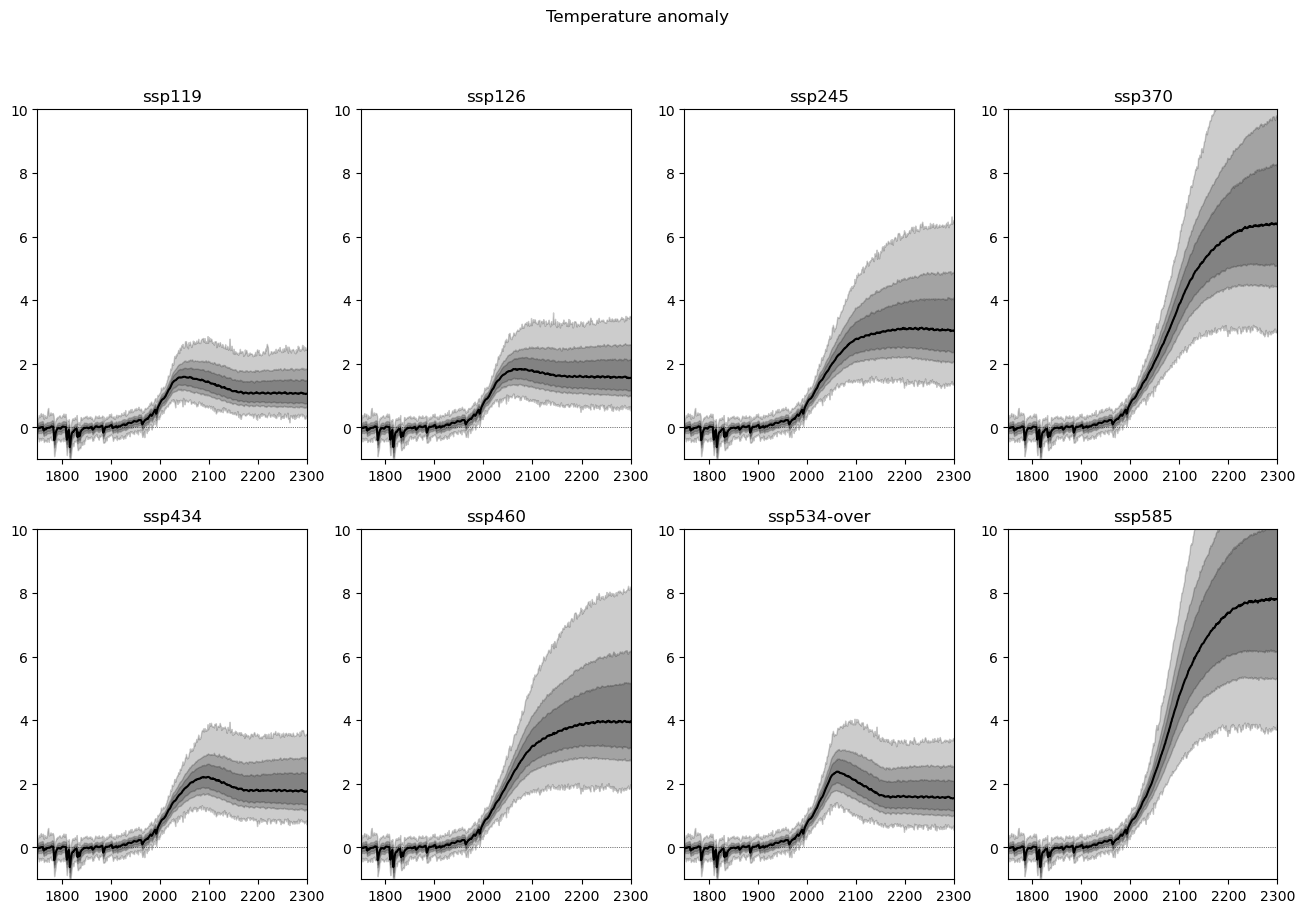

In [22]:
fig, ax = pl.subplots(2, 4, figsize=(16, 10))

for i in range(8):
    ax[i//4,i%4].fill_between(
        f.timebounds, 
        np.min(f.temperature[:, i, :, 0]-f.temperature[100:151, i, :, 0].mean(axis=0), axis=1), 
        np.max(f.temperature[:, i, :, 0]-f.temperature[100:151, i, :, 0].mean(axis=0), axis=1),
        color='#000000',
        alpha=0.2,
    )
    ax[i//4,i%4].fill_between(
        f.timebounds, 
        np.percentile(f.temperature[:, i, :, 0]-f.temperature[100:151, i, :, 0].mean(axis=0), 5, axis=1), 
        np.percentile(f.temperature[:, i, :, 0]-f.temperature[100:151, i, :, 0].mean(axis=0), 95, axis=1),
        color='#000000',
        alpha=0.2,
    )
    ax[i//4,i%4].fill_between(
        f.timebounds, 
        np.percentile(f.temperature[:, i, :, 0]-f.temperature[100:151, i, :, 0].mean(axis=0), 16, axis=1), 
        np.percentile(f.temperature[:, i, :, 0]-f.temperature[100:151, i, :, 0].mean(axis=0), 84, axis=1),
        color='#000000',
        alpha=0.2,
    )
    ax[i//4,i%4].plot(
        f.timebounds, 
        np.median(f.temperature[:, i, :, 0]-f.temperature[100:151, i, :, 0].mean(axis=0), axis=1), 
        color='#000000',
    )
    ax[i//4,i%4].set_xlim(1750,2300)
    ax[i//4,i%4].set_ylim(-1, 10)
    ax[i//4,i%4].axhline(0, color='k', ls=":", lw=0.5)
    ax[i//4,i%4].set_title(scenarios[i])
pl.suptitle('Temperature anomaly')

In [30]:
for iscen, scenario in enumerate(scenarios):
    ds = xr.Dataset(
        {
            "temperature": (["year", "run"], (f.temperature[:, iscen, :, 0] - f.temperature[100:151, iscen, :, 0].mean(axis=0)).data),
            "effective_radiative_forcing": (["year", "run"], f.forcing_sum[:, iscen, :].data),
            "ocean_heat_content_change": (["year", "run"], f.ocean_heat_content_change[:, iscen, :].data),
            "co2_concentration": (["year", "run"], f.concentration[:, iscen, :, 2].data),
            "ch4_concentration": (["year", "run"], f.concentration[:, iscen, :, 3].data),
            "n2o_concentration": (["year"], f.concentration[:, iscen, 0, 4].data),
        },
        coords={
            "year": f.timebounds,
            "run": configs
        },
    )
    ds.to_netcdf('../data_output/stochastic/%s.nc' % scenario)
    ds.close()